In [1]:
from baseband_analysis.dev.Morphology_dev import *
import matplotlib.pyplot as plt
import numpy as np
import os
from os import listdir
from os.path import isfile, join
%matplotlib inline
from chime_frb_constants import K_DM, FREQ_BOTTOM_MHZ, FREQ_TOP_MHZ
from IPython.display import clear_output

In [11]:
freq_map = np.linspace(FREQ_TOP_MHZ, FREQ_BOTTOM_MHZ, 1024)

In [4]:
def initial_guess_spec(power, freq, f_res, event_id: str = ' ', diagnostic_plots : bool = True):
    ### Doing a rpl fit to the spectra ####
    
    spectrum = get_spectrum(power) #### This will change, you will have to find limit for each peak
    
    f = rpl
    ICs = [max(spectrum),0., 0]
    ubs = [np.inf, np.inf,np.inf]
    lbs = [0, -np.inf, -np.inf]

    x = freq
    y = spectrum
    
    popt,pcov = curve_fit(f,x, y, p0=ICs, bounds = (lbs, ubs),maxfev = 100000000)
    
    print("Now plotting the results of the curve fit")
    plt.title("Spectrum, fit for data (post LS)")
    plt.plot(x,y)
    plt.plot(x,f(x, popt),color = 'orange')
    plt.xlabel("Freq MHz")
    plt.ylabel("S/N")
    plt.show()
    
    return f(x, popt), popt, np.sqrt(np.diag(pcov)), pcov 


def gaussian(x, amplitude, mean, standard_deviation):
    ''' Returns the value of the gaussian '''
    
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * standard_deviation ** 2))


def gaussian_spec(data, initial_parameters=None):
    ''' Get the upper and lower idx of a gaussian like spectrum '''
    
    x_data = np.arange(len(data)) 
    
    if initial_parameters is None:
        # Provide initial guess if not specified
        max_value = np.max(data)
        max_index = np.argmax(data)
        initial_parameters = [max_value, max_index, 1.0]  # You can adjust the initial guess

    # Perform the curve fit
    params, _ = curve_fit(gaussian, x_data, data, p0=initial_parameters)
    
    print("#############Using Gaussian parameters are#################")
    
    ##### full width tenth maxima is 4.29 sigma ######
    
    low_idx = int(params[1] - 2.145 * params[2]) 
    high_idx = int(params[1] + 2.145 * params[2])
    
    if low_idx < 0:
        low_idx = 0
    if high_idx > len(data):
        high_idx = len(data)-1
    
    print("The idx params are", low_idx, high_idx)

    return low_idx, high_idx


def bw_from_spec(power, freq, amp_pivot, specidx, specrun):
    ''' Converts rpl parameters to frequency '''
    
    spectrum = get_spectrum(power)
    
    print("Spectral running inside bw from spec function is", specrun)

    A, index, running = amp_pivot, specidx, specrun
    ref_freq = 600.0
    rpls =  A * (freq / ref_freq) ** (-index + running * np.log(freq / ref_freq)) 

    peak_frequency = freq[np.argmax(rpls)]
    
    freq_bottom_mhz = np.min(freq)
    freq_top_mhz = np.max(freq)

    pl_fwtm = np.max(rpls) / 10
    
    idx = np.argwhere(np.diff(np.sign(rpls - pl_fwtm))).flatten()
    print("The idx of sign change are", idx)
    
    if len(idx) == 0:
        pl_fwtm_freq = (freq_bottom_mhz, freq_top_mhz)
    elif len(idx) == 2 and specrun >= 0:
        if peak_frequency > 600:
            pl_fwtm_freq = (freq[idx[1]], freq_top_mhz)
        else:
            pl_fwtm_freq = (freq_bottom_mhz, freq[idx[0]])
    elif len(idx) == 2:
        pl_fwtm_freq = (freq[idx[0]], freq[idx[1]])
    elif (-40 < specrun < -2) and (len(idx) == 1):
        pl_fwtm_freq = (freq_bottom_mhz, freq_top_mhz)
    elif rpls[0] < pl_fwtm:
        pl_fwtm_freq = (freq[idx[0]], freq_top_mhz)
    else:
        pl_fwtm_freq = (freq_bottom_mhz, freq[idx[0]])

    return pl_fwtm_freq[0], pl_fwtm_freq[1], peak_frequency, rpls


def scrunch_npy(npy_fil, f_scrunch=1, t_scrunch=1):
    '''
    Scrunch data in frequency and time.
    '''
    
    ### Add cases when t_scrunch doesn't divide exactly ####
    data = npy_fil
    if (data.shape[1] % t_scrunch) == 0:
        data = data.reshape([data.shape[0] // f_scrunch, f_scrunch, data.shape[1]]).mean(axis=1)
        data = data.reshape([data.shape[0], data.shape[1] // t_scrunch, t_scrunch]).mean(axis=-1)
    else:
        t_range = data.shape[1] - (data.shape[1] % t_scrunch) ### Make the number divisible by subtrating remainder
        #print("Time range adjusted for scrunching", t_range)
        data = data[:,:t_range]
        data = data.reshape([data.shape[0] // f_scrunch, f_scrunch, data.shape[1]]).mean(axis=1)
        data = data.reshape([data.shape[0], data.shape[1] // t_scrunch, t_scrunch]).mean(axis=-1)
    return data

def get_freq_id(power : np.ndarray, freq_id : np.ndarray, downsamp_freq : int = 1, diagnostic_plots : bool = True, event_id : str = ' '):
    num_chans = power.shape[0]
    min_id = np.min(freq_id)
    print(min_id)
    
    band_frac = (1024 - np.min(freq_id)) / 1024
    print("Band fraction is", band_frac)
    
    if num_chans < 300:
        print("Very less number of channels, might not get the true bandwidth of the signal")

    #### Completing the number of channels #####
    if num_chans < 1024:
        print("Adding channels to make it 1024")
        data_full = np.zeros([1024, power.shape[-1]])
        data_full[1023 - freq_id] = power
    else:
        data_full = power
        
    ##### Using CHIME's top and bottom frequencies ####

    low = FREQ_BOTTOM_MHZ 
    if min_id > 1:
        print("The top available frequency is", freq_map[min_id])
        high = freq_map[min_id]
    else:
        high = FREQ_TOP_MHZ
    telescope_bw = high - low
    top_available_freq = high
    print("Available bandwidth is", telescope_bw)
    
    
def get_bandwidth(power : np.ndarray, freq_id : np.ndarray, downsamp_freq : int = 1, diagnostic_plots : bool = True, event_id : str = ' '):
    
    num_chans = power.shape[0]
    min_id = np.min(freq_id)
    print(min_id)
    
    band_frac = (1024 - np.min(freq_id)) / 1024
    print("Band fraction is", band_frac)
    
    if num_chans < 300:
        print("Very less number of channels, might not get the true bandwidth of the signal")

    #### Completing the number of channels #####
    if num_chans < 1024:
        print("Adding channels to make it 1024")
        data_full = np.zeros([1024, power.shape[-1]])
        data_full[1023 - freq_id] = power
    else:
        data_full = power
        
    ##### Using CHIME's top and bottom frequencies ####

    low = FREQ_BOTTOM_MHZ 
    if min_id > 50:
        print("The top available frequency is", freq_map[min_id])
        high = freq_map[min_id]
    else:
        high = FREQ_TOP_MHZ
    telescope_bw = high - low
    top_available_freq = high
    print("Available bandwidth is", telescope_bw)

    #### Scrunching the power #####

    print("Downsampling in frequency by factor of", downsamp_freq)

    power_scr = scrunch_npy(data_full, f_scrunch=downsamp_freq, t_scrunch=1)
    
    if high < FREQ_TOP_MHZ:
        power_end = int((1023 - min_id)/downsamp_freq)
        print("The scrunched power frequency ends at", power_end)
        power_scr_new = power_scr[:power_end,:]
    else:
        power_scr_new = power_scr

    f_res = 400./power_scr.shape[0]
    

    print("Frequency resolution at the given downsample is {} MHz".format(f_res))

    ###### Getting the frequencies ####

    freq = np.linspace(low, high, power_scr_new.shape[0])

    ###### Getting initial guess for the spectra ######

    fit, spec_param, spec_param_err, cov_matrix = initial_guess_spec(power_scr_new, freq, f_res, event_id = event_id, diagnostic_plots = diagnostic_plots)

    #print("Calling bw from spec function inside get bandwidth")

    bottom_freq, top_freq, peak_frequency,_ = bw_from_spec(power_scr, freq, spec_param[0], spec_param[1], spec_param[2])

    plt.imshow(power_scr, origin='lower')
    plt.yticks(np.linspace(0, power_scr.shape[0], 5), labels=['400', '500', '600', '700', '800'])        
    low_idx = np.min(np.where(bottom_freq <= freq)[0])
    high_idx = np.max(np.where(top_freq >= freq)[0])
    plt.axhline(low_idx, color = 'red')
    plt.axhline(high_idx, color = 'yellow')

    plt.show()

    ## Getting errors ####

    bottom_freq_up_err, top_freq_up_err, peak_frequency_up_err,_ = bw_from_spec(power_scr, freq, spec_param[0]+spec_param_err[0], spec_param[1]+spec_param_err[1], spec_param[2]+spec_param_err[2]) 
    bottom_freq_low_err, top_freq_low_err, peak_frequency_low_err,_ = bw_from_spec(power_scr, freq, spec_param[0]-spec_param_err[0], spec_param[1]-spec_param_err[1], spec_param[2]-spec_param_err[2])

    bottom_freq_err = bottom_freq_up_err - bottom_freq
    top_freq_err = top_freq_up_err - top_freq
    peak_frequency_err = peak_frequency_up_err - peak_frequency

    return bottom_freq, bottom_freq_err, top_freq, top_freq_err, peak_frequency, peak_frequency_err, spec_param, spec_param_err, band_frac, top_available_freq

17
Band fraction is 0.9833984375
Available bandwidth is 400.0
Downsampling in frequency by factor of 8
Frequency resolution at the given downsample is 3.125 MHz
Now plotting the results of the curve fit


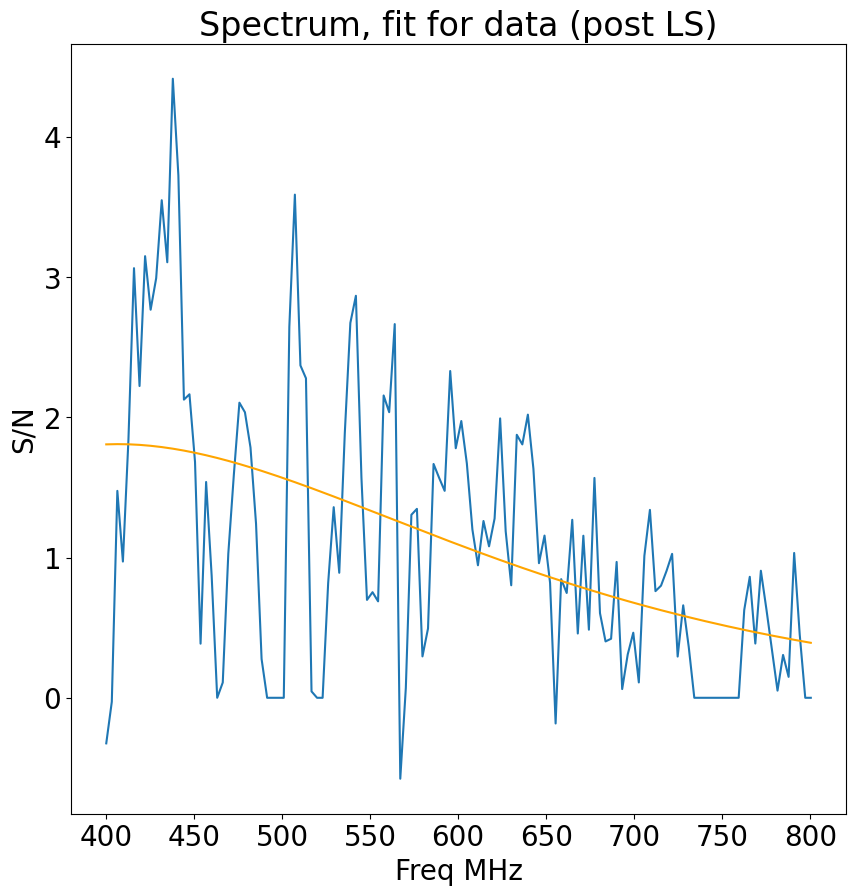

Spectral running inside bw from spec function is -3.3435894195467286
The idx of sign change are []


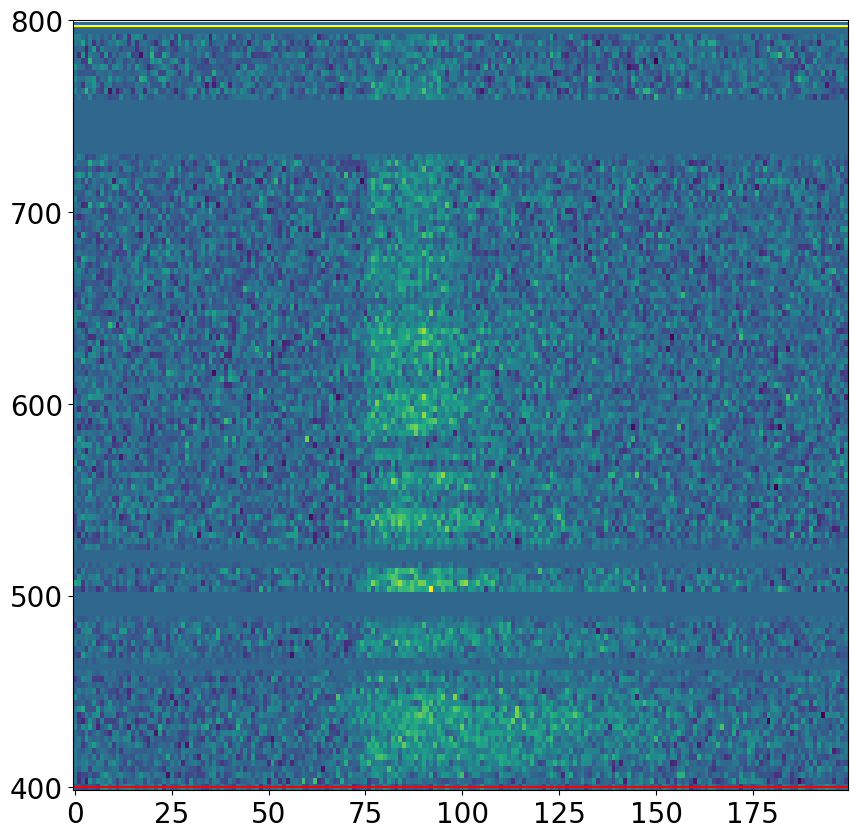

Spectral running inside bw from spec function is -1.2066709454124576
The idx of sign change are []
Spectral running inside bw from spec function is -5.480507893681
The idx of sign change are []
############The frequency parameters are#################
Bottom Frequency = 400.1953125 MHz Top Frequency = 800.1953125 MHz Peak Frequency = 406.4945250984252 MHz


In [8]:
file_path = '/arc/home/ksand/Basecat_morph/fitburst_runs/fitburst_run4/29641002/fitburst_input_29641002.npz'

data = np.load(file_path, allow_pickle = True)

power = data['data_full']

mdata = data['metadata']
metadata = mdata.item()
bad_chans = metadata['bad_chans']

freq_id = []

for i in reversed(range(1024)):
    if i not in bad_chans:
        freq_id.append(1023-i)

freq_id = np.array(freq_id)

# get_freq_id(power, freq_id, 16, False)

bottom_freq, bottom_freq_err, top_freq, top_freq_err, peak_frequency, peak_frequency_err, spec_param, spec_param_err, band_frac, avail_freq = get_bandwidth(power, freq_id, 8, False)
print("############The frequency parameters are#################")

print("Bottom Frequency = {} MHz Top Frequency = {} MHz Peak Frequency = {} MHz".format(bottom_freq, top_freq, peak_frequency))

# oname = '{}_bandwidth'.format(event)

# np.savez(oname, bandwidth_low = bottom_freq, bandwidth_low_err = bottom_freq_err, bandwidth_high = top_freq, bandwidth_high_err = top_freq_err, peak_frequency = peak_frequency, peak_frequency_err = peak_frequency_err, fit_param = spec_param, fit_param_err = spec_param_err, band_frac = band_frac, top_available_freq = avail_freq

21
Band fraction is 0.9794921875
Available bandwidth is 400.0
Downsampling in frequency by factor of 8
Frequency resolution at the given downsample is 3.125 MHz
Now plotting the results of the curve fit


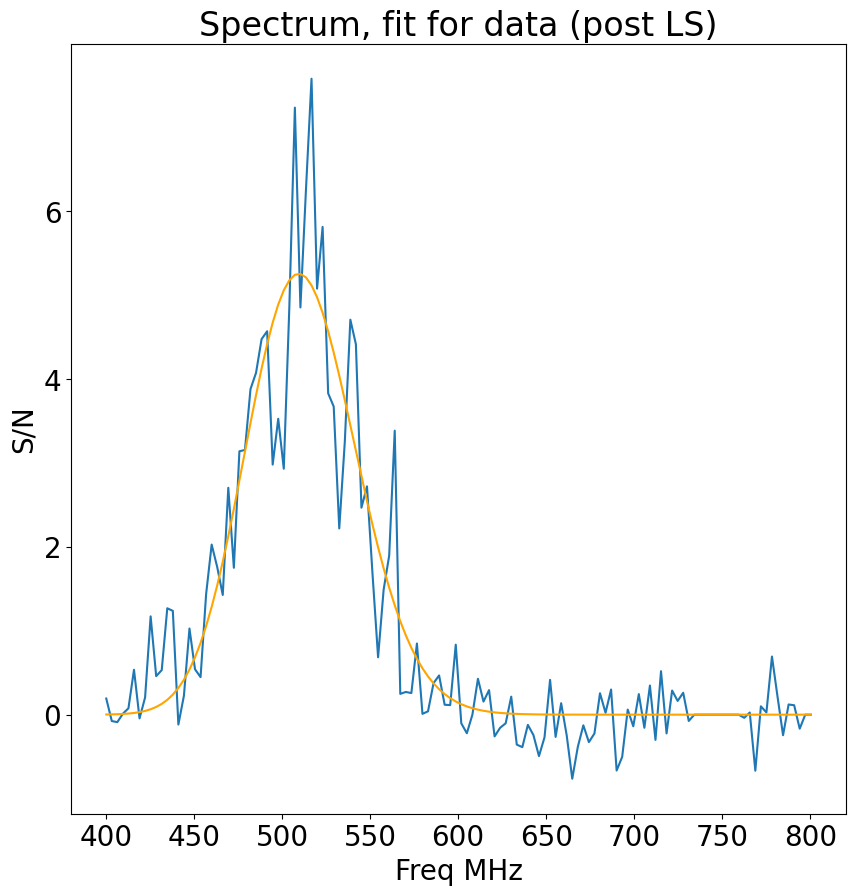

Spectral running inside bw from spec function is -135.13631252993815
The idx of sign change are [14 57]


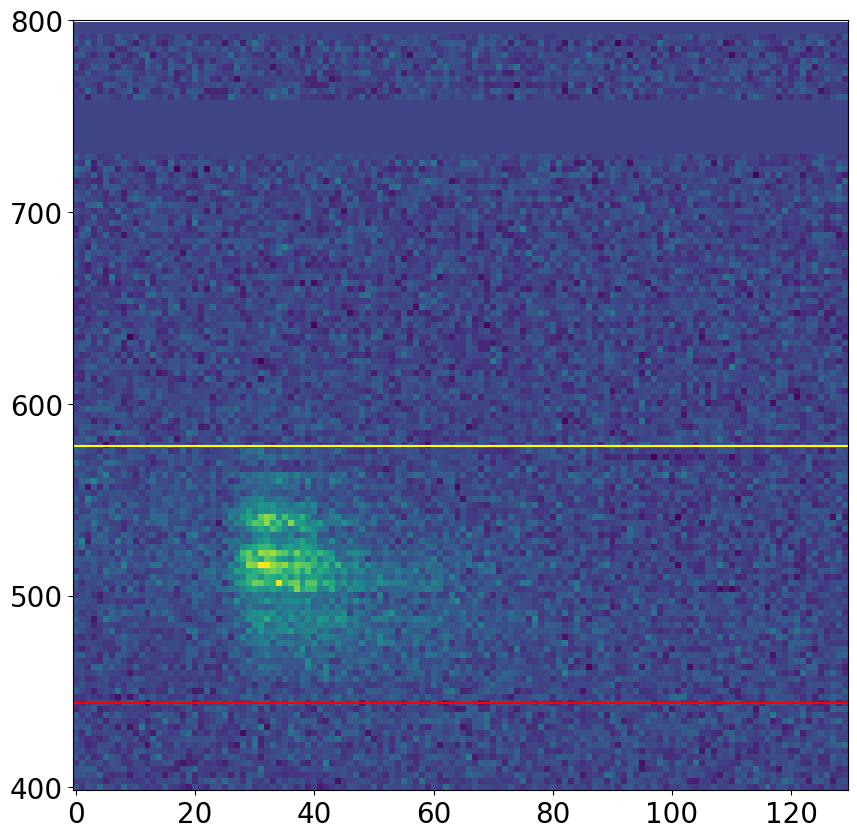

Spectral running inside bw from spec function is -124.03201546571971
The idx of sign change are [10 52]
Spectral running inside bw from spec function is -146.24060959415658
The idx of sign change are [19 60]
############The frequency parameters are#################
Bottom Frequency = 444.28980068897636 MHz Top Frequency = 579.7228715551181 MHz Peak Frequency = 510.43153297244095 MHz


In [9]:
### An example narrowband signal ####

file_path = '/arc/home/ksand/Basecat_morph/fitburst_runs/fitburst_run4/23438043/fitburst_input_23438043.npz'

data = np.load(file_path, allow_pickle = True)

power = data['data_full']

mdata = data['metadata']
metadata = mdata.item()
bad_chans = metadata['bad_chans']

freq_id = []

for i in reversed(range(1024)):
    if i not in bad_chans:
        freq_id.append(1023-i)

freq_id = np.array(freq_id)

# get_freq_id(power, freq_id, 16, False)

bottom_freq, bottom_freq_err, top_freq, top_freq_err, peak_frequency, peak_frequency_err, spec_param, spec_param_err, band_frac, avail_freq = get_bandwidth(power, freq_id, 8, False)
print("############The frequency parameters are#################")

print("Bottom Frequency = {} MHz Top Frequency = {} MHz Peak Frequency = {} MHz".format(bottom_freq, top_freq, peak_frequency))

# oname = '{}_bandwidth'.format(event)

# np.savez(oname, bandwidth_low = bottom_freq, bandwidth_low_err = bottom_freq_err, bandwidth_high = top_freq, bandwidth_high_err = top_freq_err, peak_frequency = peak_frequency, peak_frequency_err = peak_frequency_err, fit_param = spec_param, fit_param_err = spec_param_err, band_frac = band_frac, top_available_freq = avail_freq

433
Band fraction is 0.5771484375
The top available frequency is 630.8893496456501
Available bandwidth is 230.6940371456501
Downsampling in frequency by factor of 8
The scrunched power frequency ends at 73
Frequency resolution at the given downsample is 3.125 MHz
Now plotting the results of the curve fit


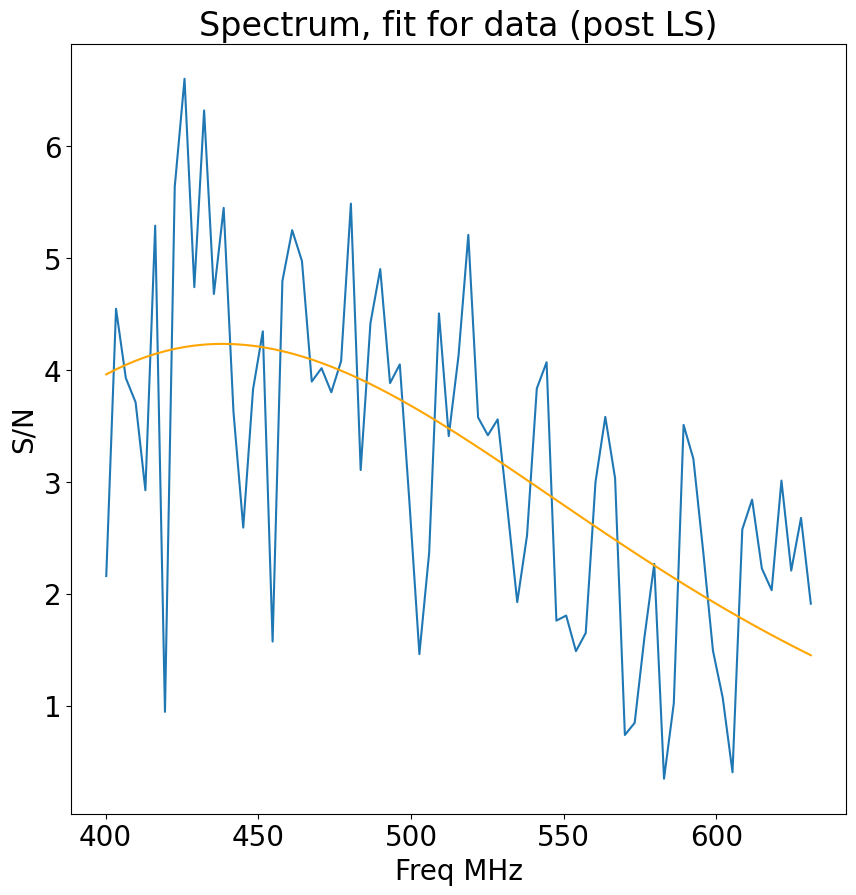

Spectral running inside bw from spec function is -8.07121590919271
The idx of sign change are []


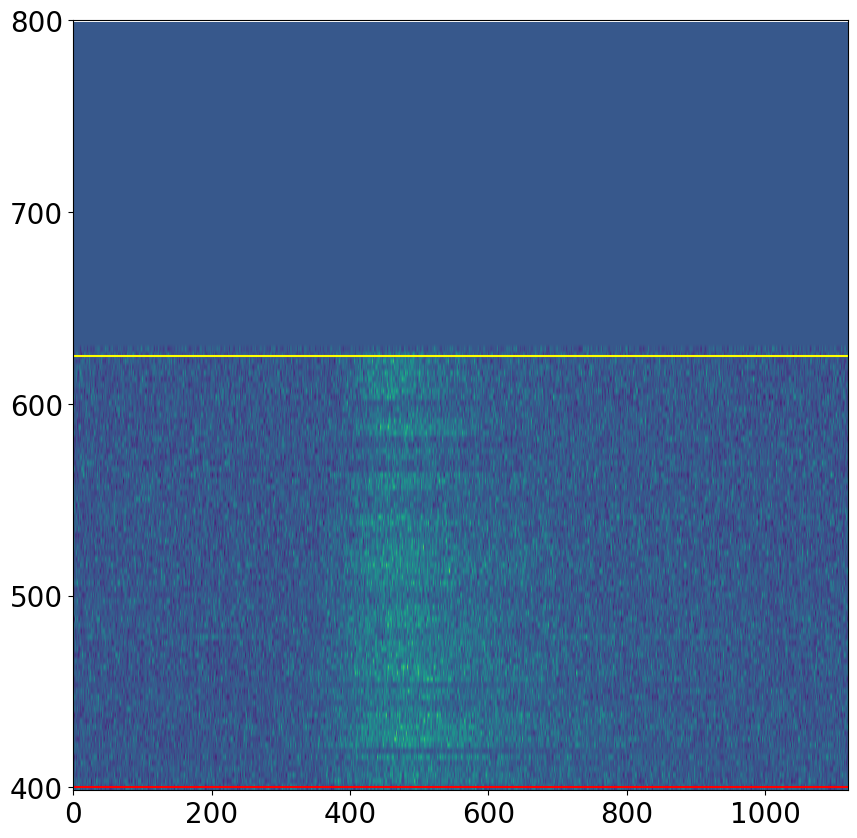

Spectral running inside bw from spec function is -5.118640069953198
The idx of sign change are []
Spectral running inside bw from spec function is -11.02379174843222
The idx of sign change are []
############The frequency parameters are#################
Bottom Frequency = 400.1953125 MHz Top Frequency = 630.8893496456501 MHz Peak Frequency = 438.6443186909417 MHz


In [12]:
### An example with missing channels ####

file_path = '/arc/home/ksand/Basecat_morph/fitburst_runs/fitburst_run4/23463808/fitburst_input_23463808.npz'

data = np.load(file_path, allow_pickle = True)

power = data['data_full']

mdata = data['metadata']
metadata = mdata.item()
bad_chans = metadata['bad_chans']

freq_id = []

for i in reversed(range(1024)):
    if i not in bad_chans:
        freq_id.append(1023-i)

freq_id = np.array(freq_id)

# get_freq_id(power, freq_id, 16, False)

bottom_freq, bottom_freq_err, top_freq, top_freq_err, peak_frequency, peak_frequency_err, spec_param, spec_param_err, band_frac, avail_freq = get_bandwidth(power, freq_id, 8, False)
print("############The frequency parameters are#################")

print("Bottom Frequency = {} MHz Top Frequency = {} MHz Peak Frequency = {} MHz".format(bottom_freq, top_freq, peak_frequency))

# oname = '{}_bandwidth'.format(event)

# np.savez(oname, bandwidth_low = bottom_freq, bandwidth_low_err = bottom_freq_err, bandwidth_high = top_freq, bandwidth_high_err = top_freq_err, peak_frequency = peak_frequency, peak_frequency_err = peak_frequency_err, fit_param = spec_param, fit_param_err = spec_param_err, band_frac = band_frac, top_available_freq = avail_freq